# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [81]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

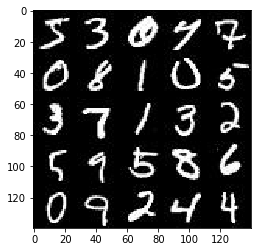

In [82]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

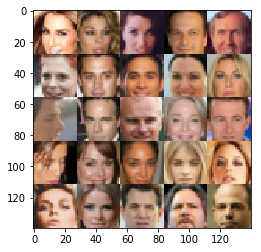

In [83]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [84]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [85]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), "input_real")
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), "input_z")
    learning_rate = tf.placeholder(tf.float32, name="input_learning_rate")
    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [110]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    n_units = 4 * 4 * 512
    alpha = 0.02
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        flat = tf.reshape(x3, (-1, n_units))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [103]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.02
    num_units = 7*7*512
    output_w_h = 28
    
    with tf.variable_scope('generator', reuse=not is_train):
        g1 = tf.layers.dense(z, num_units)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.maximum(alpha * g1, g1)
        # shape = 7x7x512
        
        g2 = tf.layers.conv2d_transpose(g1, 256, out_channel_dim, strides=2, padding='same')
        g2 = tf.layers.batch_normalization(g2, training=is_train)
        g2 = tf.maximum(alpha * g2, g2)
        # shape = 14x14x256
        
        g3 = tf.layers.conv2d_transpose(g2, 128, out_channel_dim, strides=2, padding='same')
        g3 = tf.layers.batch_normalization(g3, training=is_train)
        g3 = tf.maximum(alpha * g3, g3)    
        # shape = 28x28x128
        
        logits = tf.layers.conv2d_transpose(g3, out_channel_dim, out_channel_dim, strides=1, padding='same')
        # shape = 28x28x5
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [115]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    gen_output = generator(input_z, out_channel_dim)
    disc_output_real, disc_logits_real = discriminator(input_real)
    disc_output_fake, disc_logits_fake = discriminator(gen_output, reuse=True)
    
    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_fake,
            labels = tf.ones_like(disc_output_real) * (1 - smooth)
        )
    )
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_fake,
            labels = tf.zeros_like(disc_output_fake)
        )
    )
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_fake,
            labels = tf.ones_like(disc_output_fake)
        )
    )
    
    disc_loss = disc_loss_real + disc_loss_fake
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [116]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
        gen_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        
        return disc_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [117]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [127]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    steps = 0
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(
                    disc_opt, 
                    feed_dict={
                        input_real: batch_images, input_z: batch_z, lr: learning_rate 
                    }
                )
                _ = sess.run(
                    gen_opt, 
                    feed_dict={
                        input_real: batch_images, 
                        input_z: batch_z, 
                        lr:learning_rate
                    }
                )
                if steps == 0:
                    print('initial input:')
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = gen_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    # show samples
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    

        saver.save(sess, './generator.ckpt')
                
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 12.9249... Generator Loss: 14.3610
Epoch 1/2... Discriminator Loss: 16.6968... Generator Loss: 18.5520
Epoch 1/2... Discriminator Loss: 9.9465... Generator Loss: 0.0001
Epoch 1/2... Discriminator Loss: 3.8650... Generator Loss: 0.0310
Epoch 1/2... Discriminator Loss: 2.2615... Generator Loss: 0.1573
Epoch 1/2... Discriminator Loss: 1.9776... Generator Loss: 0.2213
Epoch 1/2... Discriminator Loss: 1.5566... Generator Loss: 0.4188
Epoch 1/2... Discriminator Loss: 1.4458... Generator Loss: 0.5426
Epoch 1/2... Discriminator Loss: 1.5478... Generator Loss: 0.4262
Epoch 1/2... Discriminator Loss: 1.4130... Generator Loss: 0.6058


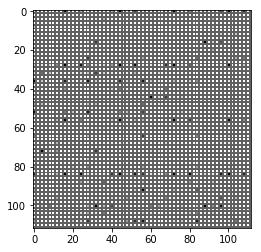

Epoch 1/2... Discriminator Loss: 1.3791... Generator Loss: 0.7411
Epoch 1/2... Discriminator Loss: 1.3791... Generator Loss: 0.7416
Epoch 1/2... Discriminator Loss: 1.3923... Generator Loss: 0.6670
Epoch 1/2... Discriminator Loss: 1.4601... Generator Loss: 0.5211
Epoch 1/2... Discriminator Loss: 1.4019... Generator Loss: 0.6349
Epoch 1/2... Discriminator Loss: 1.3820... Generator Loss: 0.7178
Epoch 1/2... Discriminator Loss: 1.3806... Generator Loss: 0.7282
Epoch 1/2... Discriminator Loss: 1.3862... Generator Loss: 0.6935
Epoch 1/2... Discriminator Loss: 1.4073... Generator Loss: 0.6201
Epoch 1/2... Discriminator Loss: 1.4075... Generator Loss: 0.6193


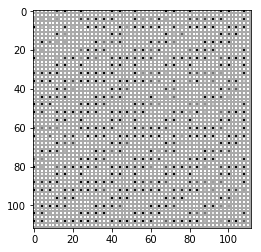

Epoch 1/2... Discriminator Loss: 1.3854... Generator Loss: 0.6978
Epoch 1/2... Discriminator Loss: 1.3799... Generator Loss: 0.7341
Epoch 1/2... Discriminator Loss: 1.3805... Generator Loss: 0.7292
Epoch 1/2... Discriminator Loss: 1.3843... Generator Loss: 0.7037
Epoch 1/2... Discriminator Loss: 1.4025... Generator Loss: 0.6330
Epoch 1/2... Discriminator Loss: 1.3979... Generator Loss: 0.6472
Epoch 1/2... Discriminator Loss: 1.3779... Generator Loss: 0.7553
Epoch 1/2... Discriminator Loss: 1.3765... Generator Loss: 0.7818
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.7879
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.7875


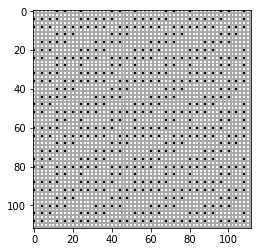

Epoch 1/2... Discriminator Loss: 1.3766... Generator Loss: 0.7804
Epoch 1/2... Discriminator Loss: 1.3793... Generator Loss: 0.7394
Epoch 1/2... Discriminator Loss: 1.4148... Generator Loss: 0.6016
Epoch 1/2... Discriminator Loss: 1.3984... Generator Loss: 0.6457
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.7858
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7955
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7973
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7981
Epoch 1/2... Discriminator Loss: 1.3771... Generator Loss: 0.7667
Epoch 1/2... Discriminator Loss: 1.3894... Generator Loss: 0.6787


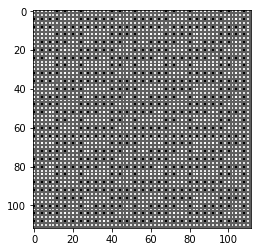

Epoch 1/2... Discriminator Loss: 1.3788... Generator Loss: 0.7448
Epoch 1/2... Discriminator Loss: 1.3767... Generator Loss: 0.7763
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.7861
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.7887
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.7876
Epoch 1/2... Discriminator Loss: 1.3765... Generator Loss: 0.7817
Epoch 1/2... Discriminator Loss: 1.3775... Generator Loss: 0.7610
Epoch 1/2... Discriminator Loss: 1.3850... Generator Loss: 0.6998
Epoch 1/2... Discriminator Loss: 1.3948... Generator Loss: 0.6579
Epoch 1/2... Discriminator Loss: 1.3784... Generator Loss: 0.7482


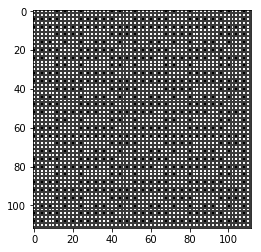

Epoch 1/2... Discriminator Loss: 1.3765... Generator Loss: 0.7835
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7925
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7948
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7935
Epoch 1/2... Discriminator Loss: 1.5928... Generator Loss: 0.3911
Epoch 1/2... Discriminator Loss: 1.4016... Generator Loss: 0.6358
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7983
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7980
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7980
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7960


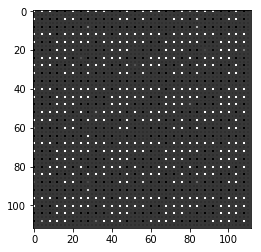

Epoch 1/2... Discriminator Loss: 1.3782... Generator Loss: 0.7511
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7984
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7950
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7996
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7987
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7999
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7967
Epoch 1/2... Discriminator Loss: 1.3766... Generator Loss: 0.7784
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7965
Epoch 1/2... Discriminator Loss: 1.3814... Generator Loss: 0.7225


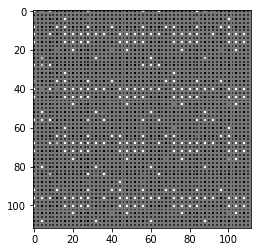

Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7976
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7971
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7980
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7983
Epoch 1/2... Discriminator Loss: 1.3765... Generator Loss: 0.8134
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7937
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7991
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7992
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7920
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7913


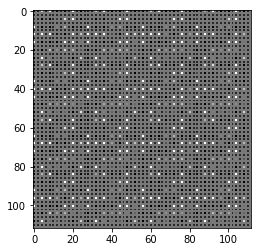

Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.7871
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7996
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7938
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7998
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7947
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7980
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7993
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.8009
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7986
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.8047


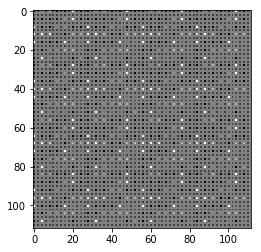

Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7988
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7897
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.8064
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.8002
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7984
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7992
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7975
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7996
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7999
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.8033


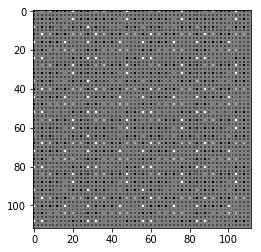

Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7994
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7917
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7976
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.8013
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.8032
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.8115
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.8102
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.8067
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.8113
Epoch 1/2... Discriminator Loss: 1.3769... Generator Loss: 0.8258


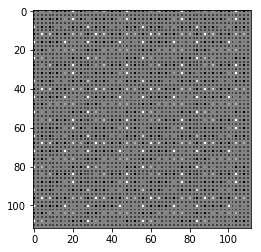

Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7995
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7969
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7980
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7981
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7987
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7989
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7982
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7966
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7945
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7913


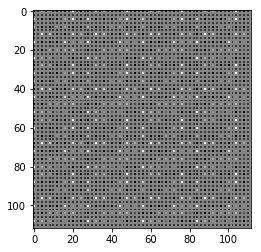

Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.7858
Epoch 1/2... Discriminator Loss: 1.3766... Generator Loss: 0.7774
Epoch 1/2... Discriminator Loss: 1.3767... Generator Loss: 0.7771
Epoch 1/2... Discriminator Loss: 1.3765... Generator Loss: 0.7818
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.7885
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7925
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7955
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7957
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7950
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7924


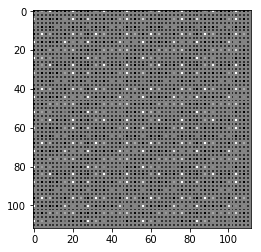

Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.7873
Epoch 1/2... Discriminator Loss: 1.3765... Generator Loss: 0.7817
Epoch 1/2... Discriminator Loss: 1.3767... Generator Loss: 0.7754
Epoch 1/2... Discriminator Loss: 1.3768... Generator Loss: 0.7746
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.7852
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7929
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7996
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.8047
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.8063
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.8023


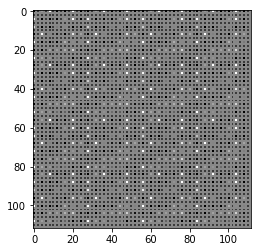

Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7959
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7905
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.7889
Epoch 1/2... Discriminator Loss: 1.3765... Generator Loss: 0.7830
Epoch 1/2... Discriminator Loss: 1.3766... Generator Loss: 0.7774
Epoch 1/2... Discriminator Loss: 1.3766... Generator Loss: 0.7786
Epoch 1/2... Discriminator Loss: 1.3766... Generator Loss: 0.7797
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.7843
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.7876
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7920


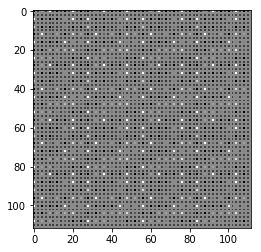

Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7947
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7965
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7979
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7987
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7965
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7964
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7969
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7948
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.7871
Epoch 1/2... Discriminator Loss: 1.3771... Generator Loss: 0.7677


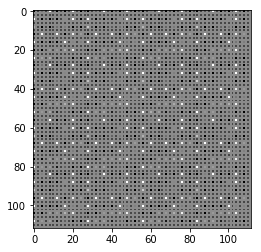

Epoch 1/2... Discriminator Loss: 1.3774... Generator Loss: 0.7624
Epoch 1/2... Discriminator Loss: 1.3768... Generator Loss: 0.7725
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.7842
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7907
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7931
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7949
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7954
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7956
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7950
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7933


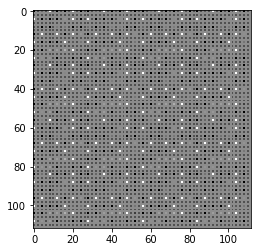

Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7902
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.7856
Epoch 1/2... Discriminator Loss: 1.3768... Generator Loss: 0.7743
Epoch 1/2... Discriminator Loss: 1.3773... Generator Loss: 0.7643
Epoch 1/2... Discriminator Loss: 1.3774... Generator Loss: 0.7620
Epoch 1/2... Discriminator Loss: 1.3768... Generator Loss: 0.7731
Epoch 1/2... Discriminator Loss: 1.3765... Generator Loss: 0.7835
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7895
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7931
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7940


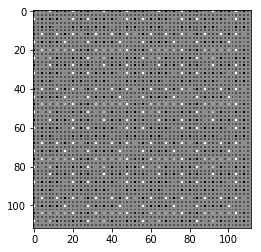

Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7938
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7912
Epoch 1/2... Discriminator Loss: 1.3766... Generator Loss: 0.7800
Epoch 1/2... Discriminator Loss: 1.3778... Generator Loss: 0.7561
Epoch 1/2... Discriminator Loss: 1.3782... Generator Loss: 0.7512
Epoch 1/2... Discriminator Loss: 1.3767... Generator Loss: 0.7758
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7914
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.7955
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.7968
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8005


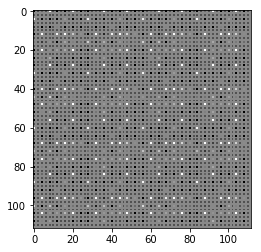

Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.7999
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8012
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8016
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8060
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8062
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.8108
Epoch 2/2... Discriminator Loss: 1.3766... Generator Loss: 0.8200
Epoch 2/2... Discriminator Loss: 1.3774... Generator Loss: 0.8354
Epoch 2/2... Discriminator Loss: 1.3777... Generator Loss: 0.8407
Epoch 2/2... Discriminator Loss: 1.3768... Generator Loss: 0.8245


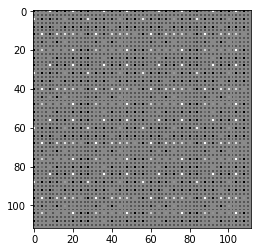

Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.8112
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8054
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8025
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8011
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8007
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8008
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8017
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8014
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8033
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8059


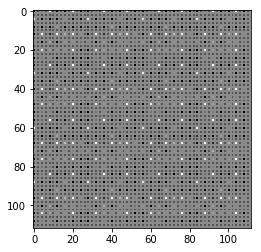

Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.8112
Epoch 2/2... Discriminator Loss: 1.3767... Generator Loss: 0.8213
Epoch 2/2... Discriminator Loss: 1.3774... Generator Loss: 0.8363
Epoch 2/2... Discriminator Loss: 1.3777... Generator Loss: 0.8412
Epoch 2/2... Discriminator Loss: 1.3770... Generator Loss: 0.8280
Epoch 2/2... Discriminator Loss: 1.3765... Generator Loss: 0.8143
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8073
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8041
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8023
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8025


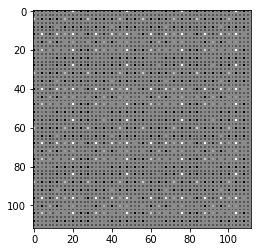

Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8028
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8026
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8036
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8057
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.8093
Epoch 2/2... Discriminator Loss: 1.3765... Generator Loss: 0.8157
Epoch 2/2... Discriminator Loss: 1.3769... Generator Loss: 0.8264
Epoch 2/2... Discriminator Loss: 1.3774... Generator Loss: 0.8361
Epoch 2/2... Discriminator Loss: 1.3772... Generator Loss: 0.8328
Epoch 2/2... Discriminator Loss: 1.3767... Generator Loss: 0.8213


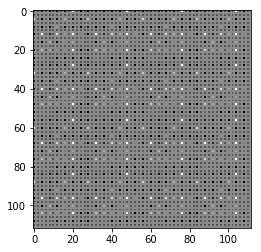

Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.8122
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8069
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8044
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8035
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8028
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8032
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8041
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8064
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.8103
Epoch 2/2... Discriminator Loss: 1.3766... Generator Loss: 0.8171


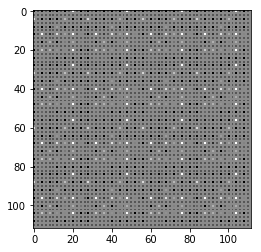

Epoch 2/2... Discriminator Loss: 1.3769... Generator Loss: 0.8274
Epoch 2/2... Discriminator Loss: 1.3774... Generator Loss: 0.8354
Epoch 2/2... Discriminator Loss: 1.3771... Generator Loss: 0.8304
Epoch 2/2... Discriminator Loss: 1.3766... Generator Loss: 0.8187
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.8103
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8059
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8042
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8030
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8034
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8035


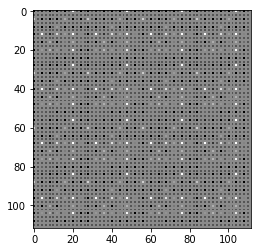

Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8038
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8048
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.8088
Epoch 2/2... Discriminator Loss: 1.3765... Generator Loss: 0.8149
Epoch 2/2... Discriminator Loss: 1.3769... Generator Loss: 0.8258
Epoch 2/2... Discriminator Loss: 1.3774... Generator Loss: 0.8365
Epoch 2/2... Discriminator Loss: 1.3773... Generator Loss: 0.8341
Epoch 2/2... Discriminator Loss: 1.3767... Generator Loss: 0.8212
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.8117
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8074


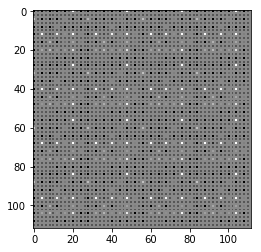

Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8033
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8027
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8015
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8021
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8034
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8045
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.8080
Epoch 2/2... Discriminator Loss: 1.3765... Generator Loss: 0.8156
Epoch 2/2... Discriminator Loss: 1.3769... Generator Loss: 0.8260
Epoch 2/2... Discriminator Loss: 1.3773... Generator Loss: 0.8347


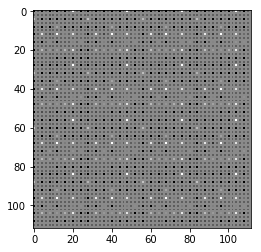

Epoch 2/2... Discriminator Loss: 1.3771... Generator Loss: 0.8303
Epoch 2/2... Discriminator Loss: 1.3766... Generator Loss: 0.8192
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.8107
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8062
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8016
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8012
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8016
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8025
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8041
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8066


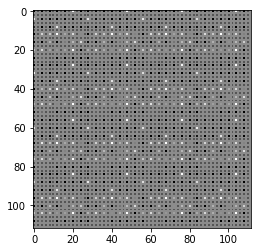

Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.8109
Epoch 2/2... Discriminator Loss: 1.3766... Generator Loss: 0.8193
Epoch 2/2... Discriminator Loss: 1.3771... Generator Loss: 0.8310
Epoch 2/2... Discriminator Loss: 1.3774... Generator Loss: 0.8354
Epoch 2/2... Discriminator Loss: 1.3769... Generator Loss: 0.8262
Epoch 2/2... Discriminator Loss: 1.3765... Generator Loss: 0.8145
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.8080
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8048
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8039
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8048


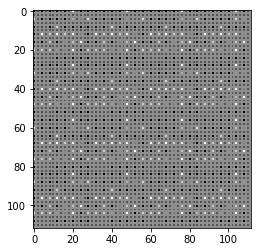

Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8053
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8077
Epoch 2/2... Discriminator Loss: 1.3765... Generator Loss: 0.8157
Epoch 2/2... Discriminator Loss: 1.3773... Generator Loss: 0.8340
Epoch 2/2... Discriminator Loss: 1.3782... Generator Loss: 0.8485
Epoch 2/2... Discriminator Loss: 1.3771... Generator Loss: 0.8301
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.8130
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8069
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8045
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8026


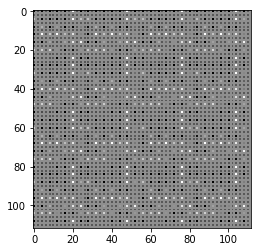

Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8030
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8033
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8037
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8051
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.8082
Epoch 2/2... Discriminator Loss: 1.3765... Generator Loss: 0.8133
Epoch 2/2... Discriminator Loss: 1.3769... Generator Loss: 0.8258
Epoch 2/2... Discriminator Loss: 1.3776... Generator Loss: 0.8402
Epoch 2/2... Discriminator Loss: 1.3772... Generator Loss: 0.8331
Epoch 2/2... Discriminator Loss: 1.3766... Generator Loss: 0.8184


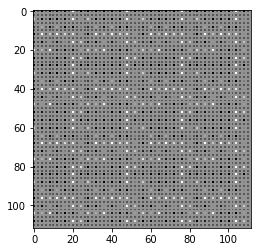

Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.8087
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8047
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8018
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8001
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8001
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8002
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.7996
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8006
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8022
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8067


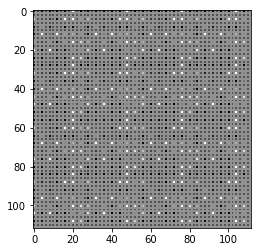

Epoch 2/2... Discriminator Loss: 1.3766... Generator Loss: 0.8191
Epoch 2/2... Discriminator Loss: 1.3774... Generator Loss: 0.8367
Epoch 2/2... Discriminator Loss: 1.3778... Generator Loss: 0.8426
Epoch 2/2... Discriminator Loss: 1.3769... Generator Loss: 0.8261
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.8117
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8061
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8031
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8016
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8002
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8010


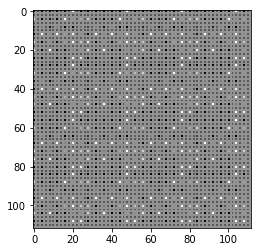

Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8006
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.7999
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8010
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8017
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8032
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8067
Epoch 2/2... Discriminator Loss: 1.3765... Generator Loss: 0.8149
Epoch 2/2... Discriminator Loss: 1.3771... Generator Loss: 0.8308
Epoch 2/2... Discriminator Loss: 1.3782... Generator Loss: 0.8479
Epoch 2/2... Discriminator Loss: 1.3776... Generator Loss: 0.8392


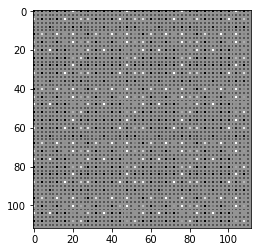

Epoch 2/2... Discriminator Loss: 1.3767... Generator Loss: 0.8201
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.8091
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8049
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8024
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8016
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8014
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8029
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8045
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8061
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.8094


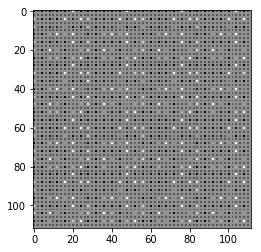

Epoch 2/2... Discriminator Loss: 1.3768... Generator Loss: 0.8242
Epoch 2/2... Discriminator Loss: 1.3778... Generator Loss: 0.8429
Epoch 2/2... Discriminator Loss: 1.3780... Generator Loss: 0.8449
Epoch 2/2... Discriminator Loss: 1.3770... Generator Loss: 0.8277
Epoch 2/2... Discriminator Loss: 1.3765... Generator Loss: 0.8168
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.8105
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8066
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8047
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8042
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8041


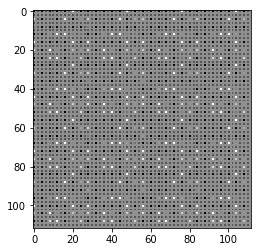

Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8042
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8047
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8064
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.8100
Epoch 2/2... Discriminator Loss: 1.3767... Generator Loss: 0.8204
Epoch 2/2... Discriminator Loss: 1.3774... Generator Loss: 0.8360
Epoch 2/2... Discriminator Loss: 1.3781... Generator Loss: 0.8473
Epoch 2/2... Discriminator Loss: 1.3780... Generator Loss: 0.8456
Epoch 2/2... Discriminator Loss: 1.3771... Generator Loss: 0.8313
Epoch 2/2... Discriminator Loss: 1.3766... Generator Loss: 0.8192


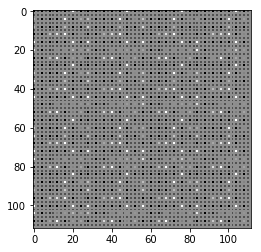

Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.8106
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8049
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8037
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8033
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8040


In [128]:
batch_size = 32
z_dim = 3
learning_rate = 0.01
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.